## Solution of Problem Set 1 - Marc Bolliger ID: 15-930-365

### Preprocessing

In [1]:
#Get list of documents

import glob
pathList = glob.glob("cases/*.txt")
pathList = pathList[:1000]
pathList[0]

'cases\\1924_X2S1O7.txt'

In [2]:
#get list with all documents and load them into dataframe
import pandas as pd
def read_from_path(path):
    with open(path, encoding="utf8") as f:
        return f.read()
    
#read files into list
files = [read_from_path(p) for p in pathList]
years = [p[6:10] for p in pathList]
caseids = [p[11:-4] for p in pathList]

df = pd.DataFrame({"caseid": caseids, "text": files, "year": years})

### 1. Split the documents into sentences and tokens

In [3]:
# load spacy english model
import spacy
nlp = spacy.load('en')
# add spacy documents to dataframe
def run_spacy(txt):
    return nlp(txt)
df['doc'] = df['text'].apply(run_spacy)

# this will come in handy for later, so save it:
df.to_pickle('corpus_with_doc_1000.pkl')

Spacy processing takes alot of time, so it is faster to load from the pickle

In [4]:
#Spacy processing takes
df = pd.read_pickle('corpus_with_doc_1000.pkl')

#### Compute number of sentences, words, and letters for each document.

In [5]:
def get_num_sents(doc):
    "return number of sentences from spacy document"
    return len(list(doc.sents))
def get_num_tokens(doc):
    "return number of tokens from spacy document"
    return len(doc)

df['num_sents'] = df['doc'].apply(get_num_sents)
df['num_tokens'] = df['doc'].apply(get_num_tokens)
df['num_chars'] = df['text'].str.len() 

#### Histogram of the number of sentences per document

In [6]:
hist = df['num_sents'].hist(bins=20, range=[0,600])

#### Histogram of the number of tokens per document

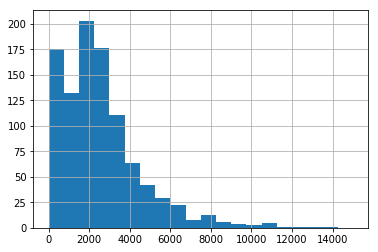

In [7]:
hist = df['num_tokens'].hist(bins=20, range=[0,15000])

#### Histogram of the number of Characters per document

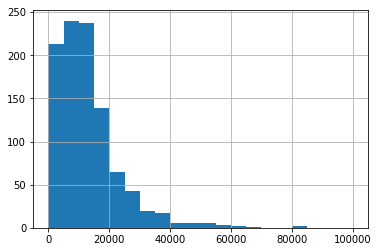

In [8]:
hist = df['num_chars'].hist(bins=20, range=[0,100000])

### 2. Using the spaCy parts of speech

In [9]:
#count number of nouns, verbs, and adjectives in each document.
def get_num_nouns(doc):
    return len(list(filter(lambda t: t.pos_ == 'NOUN' or t.pos_ == 'PROPN', doc)))
    
def get_num_verbs(doc):
    return len(list(filter(lambda t: t.pos_ == 'VERB', doc)))

def get_num_adjs(doc):
    return len(list(filter(lambda t: t.pos_ == 'ADJ', doc)))
    

df['num_nouns'] = df['doc'].apply(get_num_nouns)
df['num_verbs'] = df['doc'].apply(get_num_verbs)
df['num_adjs'] = df['doc'].apply(get_num_adjs)

In [10]:
#Get POS count by year.
pos_count = pd.DataFrame()
pos_count = df[['year', 'num_nouns', 'num_verbs', 'num_adjs']].groupby('year').sum()


In [11]:
pos_freq = pd.DataFrame()

In [12]:
#Get the frequencies of noun,verb,adjective
import numpy as np
def get_frequencies(nva_counts):
    total = np.sum(nva_counts)
    return [t/total for t in nva_counts]
    

pos_freq[['noun_freq','verb_freq','adj_freq']] = pd.DataFrame(pos_count[['num_nouns','num_verbs','num_adjs']].apply(get_frequencies, axis=1, result_type='expand'))

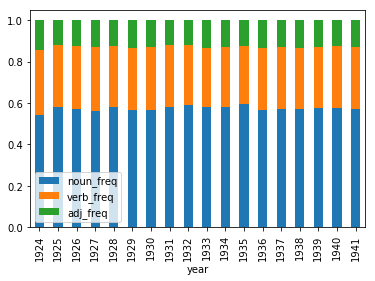

In [13]:
pos_freq.plot.bar(stacked=True);

### 3. Normalization

We use lemmatization, remove stopwords and punctuation and numbers in order to reduce the amount of tokens and to remove tokens with little information

In [14]:
from string import punctuation
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
#from nltk.stem import SnowballStemmer
#stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input spacy doc and return clean list of tokens"
    tokens = []
    #use lemmatization from spacy
    tokens = [(w.lemma_ , w.pos_) for w in doc if w.lemma_ not in [' ', '\r', '\n']+ list(punctuation)] #remove unnecessary chars
    #remove stopwords
    tokens = [w for w in tokens if w not in stoplist]
    #normalize numbers
    tokens = [w if w[1] != 'NUM' else ('#', w[1]) for w in tokens]
    #remove words with X pos tag
    tokens = [w for w in tokens if w[1] not in ['NUM', 'PUNCT']]
    
    return tokens
        
df['tokens_cleaned'] = df['doc'].apply(normalize_text)
df['tokens_cleaned'].head()

0    [(rose, PROPN), (circuit, PROPN), (judge, PROP...
1    [(kennedy, PROPN), (district, PROPN), (judge, ...
2    [(johnson, PROPN), (district, PROPN), (judge, ...
3    [(johnson, PROPN), (circuit, PROPN), (judge, P...
4    [(rogers, PROPN), (circuit, PROPN), (judge, PR...
Name: tokens_cleaned, dtype: object

In [15]:
# make a feature set of all trigrams that end in a noun.
from nltk import ngrams
def make_pos_trigrams(tokens):
    grams = ['_'.join([t[0] for t in g]) for g in ngrams(tokens,3) if g[2][1] in ['NOUN', 'PROPN']]
    return grams

df['grams'] = df['tokens_cleaned'].apply(make_pos_trigrams)
df['grams'].head()

0    [rose_circuit_judge, be_another_sugar, another...
1    [kennedy_district_judge, be_a_suit, suit_in_eq...
2    [johnson_district_judge, district_judge_appell...
3    [johnson_circuit_judge, be_a_patent, a_patent_...
4    [rogers_circuit_judge, judge_the_complainant, ...
Name: grams, dtype: object

### 4. Make dataframe

In [16]:
#while remaining sparsity? standardize to variance one?

from collections import Counter
term_frequencies = Counter()

for grams in df['grams']:
    term_frequencies.update(grams)

term_frequencies.most_common()[:10]

[('the_united_states', 2658),
 ('s._ct_l.', 2350),
 ('ct_l._ed', 2350),
 ('u._s._s.', 2322),
 ('s._s._ct', 2319),
 ('u.s._s.ct_l.ed', 1977),
 ('c._c._a.', 1630),
 ('the_supreme_court', 1362),
 ('of_the_united', 1274),
 ('of_the_act', 1124)]

Dataset with 1000 features

In [17]:
features = [t[0] for t in term_frequencies.most_common()[:1000]]

df['grams_reduced'] = df['grams'].apply( lambda x: [g for g in x if g in features])


cleaned_freqs = []
for tokens in df['grams_reduced']:
    cleaned_freqs.append(Counter(tokens)) # make a counter for each row
    
feat_df = pd.DataFrame(cleaned_freqs).fillna(0).to_sparse(fill_value=0)

feat_df.head()

,-PRON-_income_tax,a._l._r.,a._n._s.,a_common_carrier,a_direct_verdict,a_federal_court,a_labor_organization,a_national_bank,a_new_trial,a_reasonable_allowance,...,within_the_meaning,within_the_provision,within_the_scope,within_the_state,within_the_term,within_the_time,workmen_'s_compensation,writ_of_error,y._n._e.,year_in_question
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Standardize to variance one while maintaining sparsity

In [18]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

#passing with_mean=False to avoid breaking the sparsity structure of the data.
scaler = StandardScaler(with_mean=False)
#standardize it
csr_standard = scaler.fit_transform(csr_matrix(feat_df.values))
csr_standard

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 57420 stored elements in Compressed Sparse Row format>

In [19]:
#Back to sparse dataframe
features.sort()
std_feat_df = pd.SparseDataFrame(csr_standard, columns=features).fillna(0).to_sparse(fill_value=0)
std_feat_df.head()

,-PRON-_income_tax,a._l._r.,a._n._s.,a_common_carrier,a_direct_verdict,a_federal_court,a_labor_organization,a_national_bank,a_new_trial,a_reasonable_allowance,...,within_the_meaning,within_the_provision,within_the_scope,within_the_state,within_the_term,within_the_time,workmen_'s_compensation,writ_of_error,y._n._e.,year_in_question
0,0.0,0.992412,0.000000,0.0,1.878058,0.000000,0.0,0.0,1.168627,0.0,...,0.0,0.0,0.0,0.0,0.0,4.021159,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,2.010579,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,1.410384,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,2.977235,1.771135,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [20]:
std_feat_df.density

0.05742

### 5. Logistic Regression

In [21]:
#load the csv and merge it on caseid with our sampled cases
csv = pd.read_csv('case_reversed.csv')
case_rev = df.merge(csv, on='caseid')['case_reversed']

Split into train and test dataset

In [22]:
#std_feat_df['y'].head()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Split the dataset,
X_train, X_test, y_train, y_test = train_test_split(std_feat_df, case_rev, test_size=0.2, random_state=42)
#pd.read_csv('case_reversed.csv')

Train a logistic regression model

In [23]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Compute accuracy and F1 for the prediction in the training set and in the test set.

In [24]:
print('Accuracy on the train subset: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the test subset: {:.3f}'.format(log_reg.score(X_test,y_test)))

Accuracy on the train subset: 0.984
Accuracy on the test subset: 0.515


In [25]:
from sklearn.metrics import f1_score
print('F1-score on the train subset: {:.3f}'.format(f1_score(y_train,log_reg.predict(X_train))))
print('F1-score on the test subset: {:.3f}'.format(f1_score(y_test,log_reg.predict(X_test))))

F1-score on the train subset: 0.985
F1-score on the test subset: 0.446


Our current model seems to be overfitting!

### 6. Use GridSearchCV() to choose hyperparameters

L1 vs L2 penalty, and regularization parameter C

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty':['l1','l2'],'C':[0.0001,.001,.01,.1,1,10]}
grid = GridSearchCV(log_reg, param_grid, n_jobs=-1, cv=3)


In [27]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best model parameters:

In [28]:
grid.best_params_

{'C': 0.001, 'penalty': 'l2'}

Score:

In [29]:
grid.best_score_

0.5775

Report the ROC Curve and AUC.

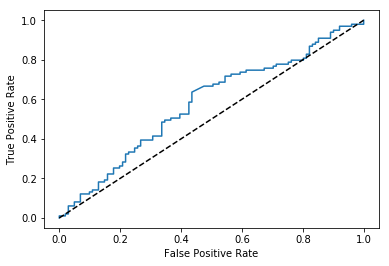

AUC: 0.578


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

probas_ = grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probas_)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_auc = auc(fpr, tpr)
plt.show()

print('AUC: {:.3f}'.format(roc_auc))

### 7. Sentence sentiment

Each sentence (of each case) is treated as a separate document.

In [31]:
#Get dataframe with each sentence as a row
sents_per_doc=df['doc'].apply(lambda x: list(x.sents))
sents = pd.Series(sents_per_doc.agg(sum))

sents_df = pd.DataFrame(sents, columns=['sent'])
sents_df['sent_text'] = sents_df['sent'].apply(lambda x: x.text)

Use vader to compute sentiments for each sentence

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def compute_sent_score(sent):
    return sid.polarity_scores(sent)['compound']

sents_df['score'] = sents_df['sent_text'].apply(compute_sent_score)

Top 10 highest sentiment sentences:

In [33]:
pd.set_option('display.max_colwidth', 320)
sents_df[['sent_text','score']].nlargest(10, columns='score')

,sent_text,score
78922,"The indictment in substance charged that the defendants and divers other persons to the grand jurors unknown, conspired to defraud the United States of and concerning its governmental function to be honestly, faithfully and dutifully represented in the Courts of the United States by an Assistant United States Attor...",0.9941
85707,"As subsidiary findings, the Board further found that resulting from an election held in July, 1934, the Petroleum Labor Policy Board certified the union as the collective bargaining agency; that soon thereafter a committee representing the union presented a proposed agreement to J. C. Thomas, superintendent of prod...",0.9930
85767,"As subsidiary findings, the Board found that following an election held in July, 1934, the Petroleum Labor Policy Board certified the union as the collective bargaining agency of the employees at the refinery; that shortly after such certification a representative of the union called upon Carl R. Tillman, superinte...",0.9929
70597,"To exercise, or to appoint proxies to exercise, any and all voting powers under any certificates or shares of stock in the trust estate; (b) to retain, or to sell, exchange, mortgage, or pledge any certificates, shares of stock, securities or other items of property or any fractional interest in any of the same now...",0.9928
25925,"It appears that the partnership, Russell & Co., Sucesores, S. en C., is composed of Horace Havemeyer, Frank A. Dillingham, Edward S. Paine, Edwin L. Arnold, Frank M. Welty, and H. B. Orde; that they are owners through purchase from Fortuna Estates of four tracts of land known as Haciendas Fortuna, Cristina, Luciana...",0.9920
11921,"It also charged conversion by the Trust Company of property of the Belt Company; also that the Trust Company occupied a fiduciary relation to the Belt Company, and by reason thereof had no right to charge any sums as profits; that the Trust Company in pursuance of a fraudulent plan sold worthless securities to the ...",0.9905
3916,"The main grounds for recovery thereof, as stated in the petition, are: ""That the assessment and collection of said additional income tax was erroneous and illegal in that it is based upon alleged income accruing to the plaintiff from the liquidating dividend upon the dissolution of the Osage Mercantile Company, a c...",0.9903
2392,"In Moore v. Crawford , supra , the Chief Justice, speaking for the court, said: ""Whenever the legal title to property is obtained through means or under circumstances 'which render it unconscientious for the holder of the legal title to retain and enjoy the beneficial interest, equity impresses a constructive trust...",0.9889
47283,"The lower court expressed very grave doubts on this question, but concluded that as there was nothing in the record to indicate the trust nature of the transaction, except the contract itself, and the fact that interest was paid, and the fact that the trust company felt perfectly free to use the money in any manner...",0.9884
665,"Appellant's contention is that the Land Commissioner and Secretary of the Interior misapplied, mistook, and misconstrued the law applicable to the facts before them, in finding and concluding as a matter of law that the several conveyances set forth in appellant's bill conveyed to and vested in the appellee the Fed...",0.9883


Top 10 lowest sentiment sentences:

In [34]:
sents_df[['sent_text','score']].nsmallest(10, columns='score')

,sent_text,score
19541,That within two or three days thereafter the appellants selected named persons to represent them and authorized such persons to investigate the fire and make estimates as to the value of the property destroyed and settle for the loss; that these adjusters for the insurers visited the scene of the fire and made exam...,-0.9914
40113,"Where a safety appliance fails to perform a function which it is intended to perform, and where such failure directly causes injury to a trainman engaged in the performance of his duties, as in the Layton Case, the Gotschall Case, and the Davis Case, the failure of the railroad company to comply with the act is cle...",-0.9800
2268,"The evidence in the case is not before us, but from instructions of the court to the jury, not excepted to, enough appears to indicate that there was no abuse of legal process in lodging a charge of conspiracy against the plaintiffs in error, and that there was evidence tending to show a conspiracy to introduce int...",-0.9796
26336,"that is, a statute permitting the relatives to recover for injuries they suffer by reason of the death of a decedent, and that under such a statute the injury to them occurred at the time of death and not at the time of the accident, and that, as the death and consequent injury to them had occurred ashore, admiralt...",-0.9788
21012,"In the second count he alleged deceased was conscious from the time he was injured until he died and on account of his injury suffered bodily pain and mental anguish from the time he was injured until he died, and prays damages in the sum of $3,000 therefor.\n",-0.9783
90095,"Fred Stevenson, a nonunion man, testified that Kemp told him that if he did not join the union, his job was not worth anything; that they would run him out of camp; that the statement was made a dozen times to him; that Kemp, Claude Johnson, Gumfory, Stewart, and Martin were present; that prior to the shut down and...",-0.9770
57991,"The resulting rule is thus stated in 38 C.J.\n1097: ""Insurer in general takes no risk with regard to the length or retardation of the voyage by the perils insured against, nor to its interruption, if it is resumed or capable of being resumed; as in the case of an embargo, or where the master is detained in port by ...",-0.9758
85349,"(2) ; the sixth, seventh, eighth, ninth and tenth each charged a use of the mails in furtherance of the scheme or artifice to defraud, in violation of section 215 of the Criminal Code 3 ; and the eleventh charged the formation of a conspiracy to violate the provisions of the Securities Act and the mail fraud statut...",-0.9750
88384,"The operators resisted these demands, but the accused forced their claims upon them in some instances by actual violence to their drivers and trucks; in some by threats of such violence; in others by persuading receiving clerks not to receive the loads.\n",-0.9744
14283,"The liability of an employer prescribed in section 4 shall be exclusive and in place of all other liability of such employer to the employee, his legal representative, husband or wife, parents, dependents, next of kin, and anyone otherwise entitled to recover damages from such employer at law or in admiralty on acc...",-0.9738


In [35]:
pd.set_option('display.max_colwidth', 80)

### 8.  TfidfVectorization

I only use 5000 sentences, to keep the amount of computation and memory low enough.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.001, # at min 0.1% of docs
                        max_df=0.5,  # at most 50% of docs
                        stop_words='english',
                        max_features=1000,
                        use_idf=True,)

N=5000
#only use 1000 sentences, otherwise the cosine similarity matrix gets too big
X =  tfidf.fit_transform(sents_df['sent_text'][:N])


In [37]:
X

<5000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 35471 stored elements in Compressed Sparse Row format>

Compute the cosine simularity

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
sent_cosim = cosine_similarity(X, dense_output=False)

In [39]:
sent_cosim

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2224226 stored elements in Compressed Sparse Row format>

In [40]:
#mask the diagonal, so max doesn't return a pair of the same sentence
sent_cosim.setdiag(0.5)

C:\Users\Marc\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [41]:
#Get max indices
smax_ind = np.argmax(sent_cosim)

smin_ind = np.argmin(sent_cosim)

x_max = smax_ind // N
y_max = smax_ind % N

x_min = smin_ind // N
y_min = smin_ind % N

Very similar sentences: 

In [42]:
print(sents_df['sent_text'][x_max]+'\n'+sents_df['sent_text'][y_max])

The nearest case is Troxell v. D., L. & W. R. R. Co. , 227 U. S. 434 , 33 S. Ct.
Referring to the case of Norrington v. Wright , 115 U. S. 188 , 6 S. Ct.


Very dissimalar sentences:

In [43]:
print(sents_df['sent_text'][x_min]+'\n'+sents_df['sent_text'][y_min])

 ROSE , Circuit Judge.

This is another sugar case.


### 9. K-means clustering

In [44]:
from sklearn.cluster import KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

labels = list(kmeans.labels_)

List 5 example sentences from each cluster. 

In [45]:
for i in range(1,n_clusters+1):
    print("Sentences in cluster {}: \n".format(i))
    for j in range(5):
        if i in labels:
            index = labels.index(i)
            labels.remove(i)
            #replace
            labels.insert(index,0)
            print("Index: {}, Sentence: {} ".format(index, sents_df['sent_text'][index]))
        else: break
    print("\n")
        

Sentences in cluster 1: 

Index: 1, Sentence: This is another sugar case. 
Index: 2, Sentence: Those concerned in the transactions out of which it arose will be referred to as the seller, the buyer, and the bank.
 
Index: 3, Sentence: Only the first and last of these are parties to this litigation.
 
Index: 4, Sentence: The seller was plaintiff below and is defendant in error here.
 
Index: 5, Sentence: It is a partnership trading as Lamborn & Co., and is composed of nearly a dozen persons, every one of whom is a citizen of some other state than Virginia.
 


Sentences in cluster 2: 

Index: 210, Sentence: v. Moffat Tunnel Improvement District , 262 U. S. 710 , 43 S. Ct. 
Index: 269, Sentence: 187 , 43 L. Ed. 
Index: 440, Sentence: That principle was again stated in the recent case of Adkins v. Children's Hospital , 261 U. S. 525, 544 , 43 S. Ct. 
Index: 692, Sentence: , 43 L. Ed. 
Index: 965, Sentence: Brownlow v. Schwartz , 261 U. S. 216 , 43 S. Ct. 


Sentences in cluster 3: 

Index

 
Index: 190, Sentence: "Obviously, the railroad companies have not been treated like individual owners, and we think the discrimination so palpable and arbitrary as to amount to a denial of the equal protection of the law.
 
Index: 197, Sentence: Equal protection of the law must be extended to all."
 


Sentences in cluster 12: 

Index: 928, Sentence: The term "trade secrets," as ordinarily understood, means an unpatented, secret, commercially valuable plan, appliance, formula, or process, which is used for the making, preparing, compounding, treating, or processing of articles or materials which are trade commodities.
 
Index: 937, Sentence: Business privacy will be protected, it is true, from mere fishing expeditions in search of evidence ( Federal Trade Commission v. American Tobacco Co. , 264 U. S. 298, 305-306 , 44 S. Ct. 
Index: 1042, Sentence: This is an original proceeding brought in this court by the Federal Trade Commission, hereafter referred to as "the Commission," under t